# Energy management with convex storage losses models

In particular, testing the "Convex monomial" losses model introduced in "Convex storage losses modeling for Energy
Management" article.

Optimization solvers:
- ECOS for LP
- Iptot solver, since it can accept any _nonlinear_ optimization problem.

PH, July–Npv 2020

<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Software-test" data-toc-modified-id="Software-test-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Software test</a></span></li><li><span><a href="#Test-case:-energy-arbitrage" data-toc-modified-id="Test-case:-energy-arbitrage-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Test case: energy arbitrage</a></span><ul class="toc-item"><li><span><a href="#Experience-definition" data-toc-modified-id="Experience-definition-2.1"><span class="toc-item-num">2.1&nbsp;&nbsp;</span>Experience definition</a></span></li><li><span><a href="#0.-Defining-a-base-problem-in-JuMP" data-toc-modified-id="0.-Defining-a-base-problem-in-JuMP-2.2"><span class="toc-item-num">2.2&nbsp;&nbsp;</span>0. Defining a base problem in JuMP</a></span></li><li><span><a href="#LP-version:-no-losses" data-toc-modified-id="LP-version:-no-losses-2.3"><span class="toc-item-num">2.3&nbsp;&nbsp;</span>LP version: no losses</a></span><ul class="toc-item"><li><span><a href="#Variant:-linear-in-$E_b$-losses-(self-discharge)" data-toc-modified-id="Variant:-linear-in-$E_b$-losses-(self-discharge)-2.3.1"><span class="toc-item-num">2.3.1&nbsp;&nbsp;</span>Variant: linear-in-$E_b$ losses (self discharge)</a></span></li></ul></li><li><span><a href="#LP:-piecewise-linear-losses-(PWL)" data-toc-modified-id="LP:-piecewise-linear-losses-(PWL)-2.4"><span class="toc-item-num">2.4&nbsp;&nbsp;</span>LP: piecewise linear losses (PWL)</a></span><ul class="toc-item"><li><span><a href="#When-PWL-losses-are-high" data-toc-modified-id="When-PWL-losses-are-high-2.4.1"><span class="toc-item-num">2.4.1&nbsp;&nbsp;</span>When PWL losses are high</a></span></li></ul></li><li><span><a href="#SOCP-version:-no-losses,-penalty-for-RMS-value-of-$P_b$" data-toc-modified-id="SOCP-version:-no-losses,-penalty-for-RMS-value-of-$P_b$-2.5"><span class="toc-item-num">2.5&nbsp;&nbsp;</span>SOCP version: no losses, penalty for RMS value of $P_b$</a></span></li><li><span><a href="#QCQP-version:-quadratic-storage-losses" data-toc-modified-id="QCQP-version:-quadratic-storage-losses-2.6"><span class="toc-item-num">2.6&nbsp;&nbsp;</span>QCQP version: quadratic storage losses</a></span><ul class="toc-item"><li><span><a href="#Variant-with-higher-losses" data-toc-modified-id="Variant-with-higher-losses-2.6.1"><span class="toc-item-num">2.6.1&nbsp;&nbsp;</span>Variant with higher losses</a></span></li></ul></li><li><span><a href="#NLP-version:-convex-losses-R(SoE).$P_{sto}^2$" data-toc-modified-id="NLP-version:-convex-losses-R(SoE).$P_{sto}^2$-2.7"><span class="toc-item-num">2.7&nbsp;&nbsp;</span>NLP version: convex losses R(SoE).$P_{sto}^2$</a></span><ul class="toc-item"><li><span><a href="#Looking-at-duals-(shadow-prices)" data-toc-modified-id="Looking-at-duals-(shadow-prices)-2.7.1"><span class="toc-item-num">2.7.1&nbsp;&nbsp;</span>Looking at duals (shadow prices)</a></span></li></ul></li><li><span><a href="#Charge/discharge-asymetric-losses" data-toc-modified-id="Charge/discharge-asymetric-losses-2.8"><span class="toc-item-num">2.8&nbsp;&nbsp;</span>Charge/discharge asymetric losses</a></span></li></ul></li></ul></div>

In [1]:
using Printf
using JuMP
# Solvers
using Ipopt
using ECOS
# Plot
using PyPlot

## Software test (JuMP+Ipopt)

Test of Ipopt with JuMP on smooth nonlinear problem ([Rosenbrock_function](https://en.wikipedia.org/wiki/Rosenbrock_function))

$$\min_{x,y} J(x,y) = (1 - x)^2 + 100 (y - x^2)^2$$

In [3]:
model = Model(Ipopt.Optimizer)
@variable(model, x, start = 0.0)
@variable(model, y, start = 0.0)

@NLobjective(model, Min, (1 - x)^2 + 100 * (y - x^2)^2)

set_silent(model) # suppress Ipopt output

optimize!(model)
@printf("Rosebrock argmin: x = %.3f, y = %.3f\n", value(x), value(y))

# adding a linear constraint
@constraint(model, x + y == 10)
optimize!(model)
@printf("Rosebrock argmin: x = %.3f, y = %.3f (with constraint x+y=10)\n", value(x), value(y))

Rosebrock argmin: x = 1.000, y = 1.000
Rosebrock argmin: x = 2.701, y = 7.299 (with constraint x+y=10)


## Test case A: energy arbitrage with load shifting

System: grid (power $P_{grid}$), storage ($P_b$, with receptor convention) and load ($P_{load}$).

Power flow conservation:
$$ P_{grid} = P_{load} + P_b $$

Storage dynamics:
$$E_b(k+1) = E_b(k+1) + (P_b(k)-P_{loss}(k))\Delta_t$$

Objective: minimize grid consumption cost:

$$ \min C_{grid} = \sum_{k} c_{grid}(k) P_{grid}(k)$$

### Experience definition

Scenario: a two hours experience with:

- first hour: low electricity price (0.1 €/kWh), no load
- second hour: high price (0.2 €/kWh), 1 kW load (i.e. 1kWh consumption)

Parameters: 
- 1.2 kWh battery, to allow a 100% load shifting including losses
- 1.5 kW grid, to allow non constant charging

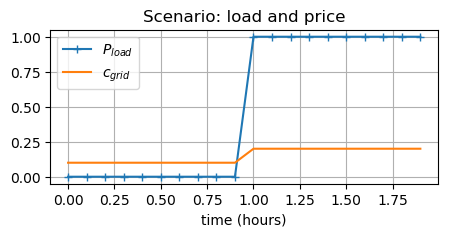

In [3]:
# Time vector: 2 hours, 0.1 h time step
n = 2*10
dt = 0.1
t = (0:n-1)*dt;

E_rated = 1.2 # kWh
P_grid_max = 1.5 # kW
P_load = [zeros(n÷2)
          ones(n÷2)]
c_grid = [ones(n÷2)*0.1
          ones(n÷2)*0.2] # €/kWh

figure(figsize=(5,2.))
plot(t, P_load, "+-", label="\$P_{load}\$")
plot(t, c_grid, label="\$c_{grid}\$")
xlabel("time (hours)")
title("Scenario: load and price")
legend()
grid(true)

### 0. Defining a base problem in JuMP

to be reused by all subsequent problems

In [40]:
"""
    arbritrage_base(optimizer)

Create a base JuMP pour the arbitrage optimization problem.
P_loss variable needs to be constrained.

`optimizer` should be an optimized factory passed to `JuMP.Model`.

If `slit_Pb` is true, then two extra variables are introduced:
`Pb_pos` and `Pb_neg`, the positive and negative parts of the
storage power `Pb`. That is Pb == Pb_pos - Pb_neg.
"""
function arbritrage_base(optimizer; split_Pb=false)
    m = Model(optimizer)
    # silence solver output
    set_silent(m)
    
    # Variables:
    @variable(m, 0. <= Eb[1:n+1] <= E_rated) # storage energy
    @variable(m, Pb[1:n]) # storage power
    @variable(m, P_losses[1:n]) # storage losses
    @variable(m, 0. <= P_grid[1:n] <= P_grid_max) # grid power
    @variable(m, C_grid) # Total grid cost
    
    # Power flow
    @constraint(m, Pcons[k = 1:n],
                P_grid[k] == Pb[k] + P_load[k])
    # Storage dynamics
    @constraint(m, Edyn[k = 1:n], 
                Eb[k+1] == Eb[k] + (Pb[k] - P_losses[k])*dt)
    # Initial energy: empty
    @constraint(m, Eb_ini, Eb[1] == 0.)
    # Total grid cost
    @constraint(m, C_grid == sum(P_grid .* c_grid)*dt)
    
    if split_Pb
        @variable(m, Pb_pos[1:n] >= 0.) # storage power positive part
        @variable(m, Pb_neg[1:n] >= 0.) # storage power negative part
        
        @constraint(m, Pb .== Pb_pos - Pb_neg)
    end
    
    @objective(m, Min, C_grid)
    
    return m
end

arbritrage_base

In [37]:
methods(arbritrage_base)

# 2 methods for generic function "arbritrage_base":
[1] arbritrage_base(optimizer) in Main at In[35]:14
[2] arbritrage_base(optimizer, split_Pb) in Main at In[35]:14

Plot

In [13]:
figsize = (5,3)

(5, 3)

In [31]:
"""
    arbitrage_plot(model)

Plot the optimization results of arbitrage scenario from JuMP `model`
"""
function arbitrage_plot(model, title_start="")
    # Check optimization
    if termination_status(m) != MOI.OPTIMAL &&  termination_status(m) != MOI.LOCALLY_SOLVED
        error("The model was not solved correctly.")
    end
    
    # Collect results
    P_grid = value.(m[:P_grid])
    Pb = value.(m[:Pb])
    Eb = value.(m[:Eb])
    P_losses = value.(m[:P_losses])
    
    E_grid = round(sum(P_grid)*dt, digits=6)
    C_grid = round(value.(m[:C_grid]), digits=6)
    
    # Plot:
    figure(figsize = figsize)
    plot(t, P_grid, "x-", label="\$P_{grid}\$", ms=10)
    plot(t, Eb[1:end-1], "+-", label="\$E_b\$")
    plot(t, Pb, "o-", label="\$P_b\$")
    plot(t, P_losses, "^-", label="\$P_{losses}\$")
    
    legend()
    #xlabel("time (hours)")
    #ylabel("kW, kWh")
    ylim(-1.15, 1.65)
    title(@sprintf("%s (\$E_{grid}\$ %.3f kWh, \$C_{grid}\$ %.4f €)", title_start, E_grid, C_grid))
    grid(true)
    tight_layout()
end

arbitrage_plot

### LP version: no losses

and adding a small discount on $P_{grid}$ for unicity

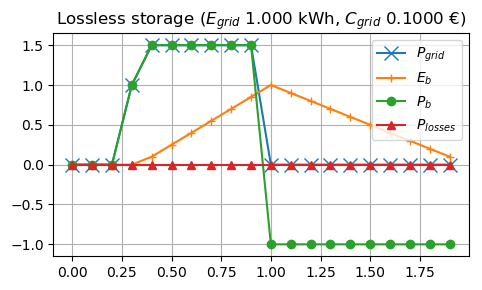

In [32]:
m = arbritrage_base(ECOS.Optimizer)

# no losses:
@constraint(m, losses, m[:P_losses] .== 0.0)

seq0_1 = (0:n-1)/(n-1) # increasing sequence from 0 to 1 on k=1:n
discount = (1 .- seq0_1) * 1e-5

# Redefine the objective to add the penalty:
@objective(m, Min, m[:C_grid] + sum(m[:P_grid] .* discount))

optimize!(m)

arbitrage_plot(m, "Lossless storage")

#### Variant: linear-in-$E_b$ losses (self discharge)

$P_{losses} = c_E E_b$

-> makes the solution unique wih the need for the decreasing penalty of $P_{grid}$.
Indeed, there is an interest to delay recharge as much as possible.

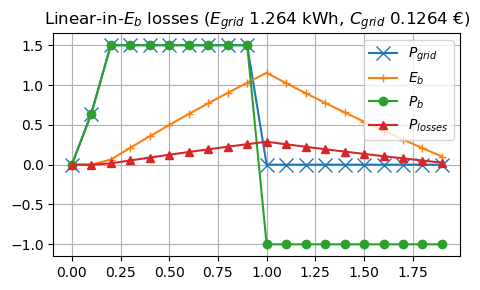

Max stored energy: Eb(1h) = 1.1525 kWh

In [33]:
m = arbritrage_base(ECOS.Optimizer)

# discharge proportional to storage energy:
@constraint(m, losses, m[:P_losses] .== 0.25*m[:Eb][1:end-1])

optimize!(m)

arbitrage_plot(m, "Linear-in-\$E_b\$ losses")

@printf("Max stored energy: Eb(1h) = %.4f kWh", value(m[:Eb][n÷2+1]))

### LP: piecewise linear losses (PWL)

Formulated using splitting of positive and negative parts Pb+ and Pb-

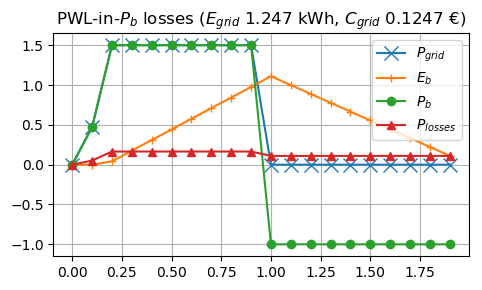

Max stored energy: Eb(1h) = 1.1100 kWh

In [47]:
m = arbritrage_base(ECOS.Optimizer, split_Pb=true)

# PWL losses
c = 0.11
@constraint(m, losses, m[:P_losses] .== c*m[:Pb_pos] + c*m[:Pb_neg])

seq0_1 = (0:n-1)/(n-1) # increasing sequence from 0 to 1 on k=1:n
discount = (1 .- seq0_1) * 1e-5

# Redefine the objective to add the penalty:
@objective(m, Min, m[:C_grid] + sum(m[:P_grid] .* discount))

optimize!(m)

arbitrage_plot(m, "PWL-in-\$P_b\$ losses")
@printf("Max stored energy: Eb(1h) = %.4f kWh", value(m[:Eb][n÷2+1]))

#### When PWL losses are high

c = 0.33 seems to be the turning point

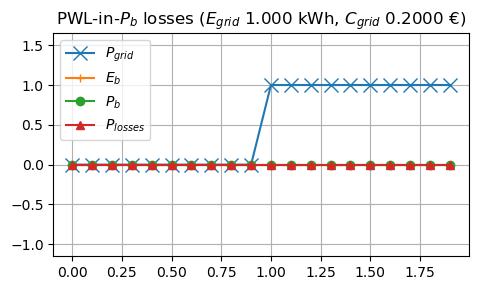

Max stored energy: Eb(1h) = 0.0000 kWh

In [57]:
m = arbritrage_base(ECOS.Optimizer, split_Pb=true)

# PWL losses
c = 0.34 # 0.31
@constraint(m, losses, m[:P_losses] .== c*m[:Pb_pos] + c*m[:Pb_neg])

seq0_1 = (0:n-1)/(n-1) # increasing sequence from 0 to 1 on k=1:n
discount = (1 .- seq0_1) * 1e-5

# Redefine the objective to add the penalty:
@objective(m, Min, m[:C_grid] + sum(m[:P_grid] .* discount))

optimize!(m)

arbitrage_plot(m, "PWL-in-\$P_b\$ losses")
@printf("Max stored energy: Eb(1h) = %.4f kWh", value(m[:Eb][n÷2+1]))

### SOCP version: no losses, penalty for RMS value of $P_b$

RMS value of the storage power, in discrete time:

$$ P_{b,rms} = \sqrt{\sum_{k=1}^n P_b^2(k)/n} = \lVert P_b \rVert / \sqrt{n}$$

This can be written as a SOC constraint (see [JuMP doc on quadratic constraints](https://jump.dev/JuMP.jl/stable/constraints/#Quadratic-constraints-1)):

$$ \lVert P_b \rVert \leq P_{b,rms}.\sqrt{n} $$

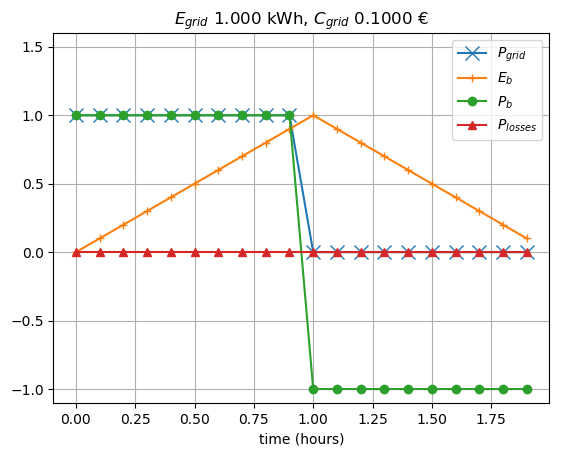

Pb_rms: 1.000 kW

In [60]:
m = arbritrage_base(ECOS.Optimizer)

# no losses:
@constraint(m, losses, m[:P_losses] .== 0.0)

@variable(m, Pb_rms)
@constraint(m, [Pb_rms*sqrt(n); m[:Pb]] in SecondOrderCone())

# Redefine the objective to add the penalty:
@objective(m, Min, m[:C_grid] + 0.01*Pb_rms) # penalty coefficient should be < 0.1

optimize!(m)

arbitrage_plot(m)

Pb_rms = value(Pb_rms)
@printf("Pb_rms: %.3f kW", Pb_rms)

Variant with moderately high penalty: 0.1 is a turning point

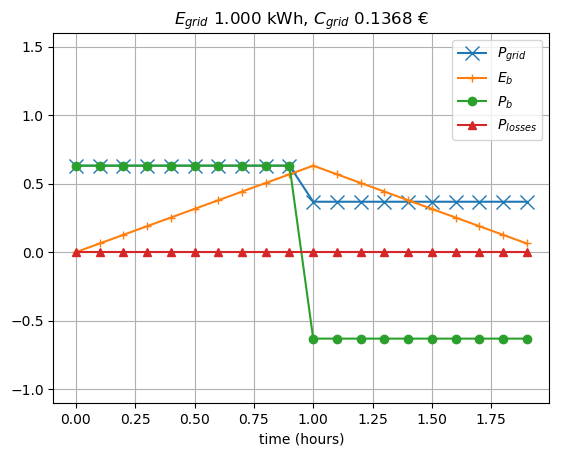

Pb_rms: 0.632 kW

In [61]:
m = arbritrage_base(ECOS.Optimizer)

# no losses:
@constraint(m, losses, m[:P_losses] .== 0.0)

@variable(m, Pb_rms)
@constraint(m, [Pb_rms*sqrt(n); m[:Pb]] in SecondOrderCone())

# Redefine the objective to add the penalty:
@objective(m, Min, m[:C_grid] + 0.1*Pb_rms) # penalty coefficient should be < 0.1

optimize!(m)

arbitrage_plot(m)

Pb_rms = value(Pb_rms)
@printf("Pb_rms: %.3f kW", Pb_rms)

### QCQP version: quadratic storage losses

Quadratic loss model

$$P_{loss} = \rho P_{sto}^2$$

**Note** why does it work with ECOS? I thought ECOS only accepted SOC constraints, not generic quadratic ones

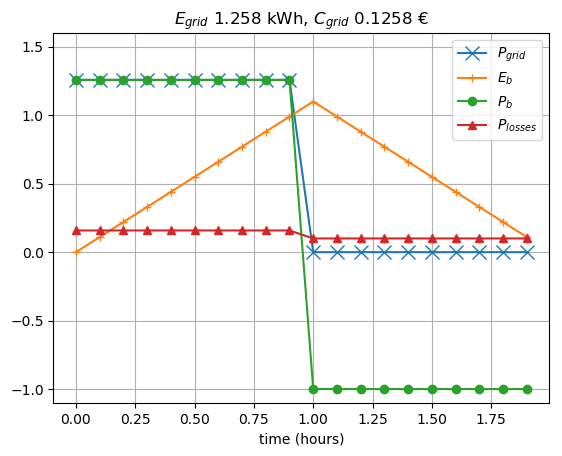

In [72]:
ρ0 = 0.1 # kW/kW²

m = arbritrage_base(ECOS.Optimizer)

# Quadratic losses as (convex) Quad Constraint:
@constraint(m, losses, m[:P_losses] .>= ρ0 * m[:Pb].^2)

optimize!(m)

arbitrage_plot(m)

Check that there are not excess of losses

In [73]:
P_excess = value.(m[:P_losses] - ρ0 * m[:Pb].^2)
maximum(abs.(P_excess))

4.936663300370014e-10

#### Variant with higher losses

-> Arbitrage becomes fractional: grid is used to partially feed the load

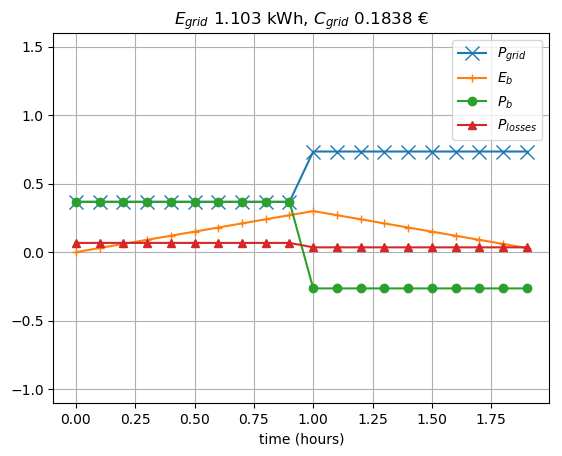

In [74]:
ρ0 = 0.5 # kW/kW²

m = arbritrage_base(ECOS.Optimizer)

# Quadratic losses as (convex) Quad Constraint:
@constraint(m, losses, m[:P_losses] .>= ρ0 * m[:Pb].^2)

optimize!(m)

arbitrage_plot(m)

### NLP version: convex losses R(SoE).$P_{sto}^2$

See JuMP doc on [Nonlinear Modeling](https://jump.dev/JuMP.jl/v0.21.1/nlp/)


$$P_{loss} = \frac{c}{(E_b - e_0)^a} P_{sto}^2$$

In [190]:
c = 0.07
a = 1.
e0 = -0.25*E_rated

-0.3

Show the loss factor $\rho(E_b)$ 

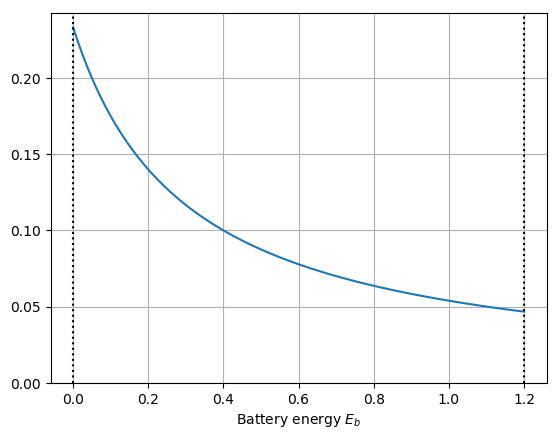

In [191]:
Eb_list = range(0, E_rated, length=100)

ρ_Eb = c./(Eb_list .- e0).^a

plot(Eb_list, ρ_Eb)
xlabel("Battery energy \$E_b\$")
axvline(0, color="k", ls=":")
axvline(E_rated, color="k", ls=":")
ylim(ymin=0)
grid()

Solve

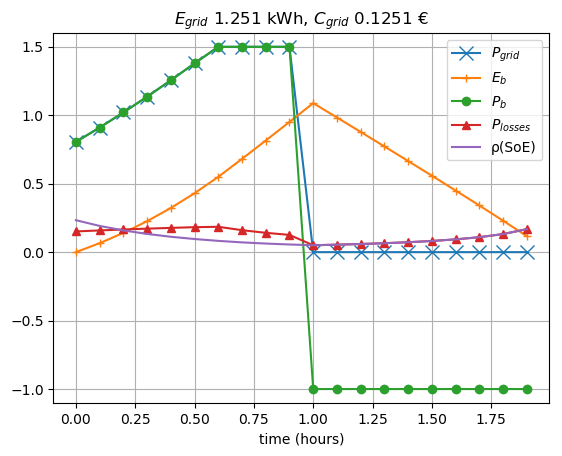

In [192]:
m = arbritrage_base(Ipopt.Optimizer)

# Convex monomial losses expression
@NLexpression(m, ρ[k = 1:n], c/(m[:Eb][k] - e0)^a)
@NLconstraint(m, losses[k = 1:n], m[:P_losses][k] >= ρ[k] * m[:Pb][k]^2)

# Optimize and check result
optimize!(m)

arbitrage_plot(m)

ρ = value.(ρ)

plot(t, ρ, "-", label="ρ(SoE)")
legend();

Now, with a bit more losses,there a help from the grid to feed the load during the end of discharge

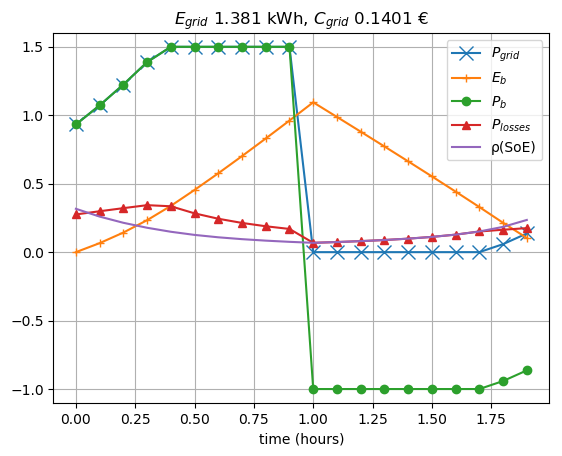

In [202]:
c = 0.095

m = arbritrage_base(Ipopt.Optimizer)

# Convex monomial losses expression
@NLexpression(m, ρ[k = 1:n], c/(m[:Eb][k] - e0)^a)
@NLconstraint(m, losses[k = 1:n], m[:P_losses][k] >= ρ[k] * m[:Pb][k]^2)

# Optimize and check result
optimize!(m)

arbitrage_plot(m)

ρ = value.(ρ)

plot(t, ρ, "-", label="ρ(SoE)")
legend();

Checking the absence of excess losses: OK

In [203]:
P_excess = value.(m[:P_losses] - ρ .* m[:Pb].^2)
maximum(abs.(P_excess))

1.6587044870952639e-7

#### Looking at duals (shadow prices)

TO BE CONTINUED

In [204]:
[dual.(m[:Edyn]) dual.(m[:losses]) dual.(m[:Pcons]) ]

20×3 Array{Float64,2}:
 -0.244257  0.0244257  0.01
 -0.225811  0.0225811  0.01
 -0.210538  0.0210538  0.01
 -0.197811  0.0197811  0.01
 -0.187938  0.0187938  0.0103967
 -0.181134  0.0181134  0.0112701
 -0.176225  0.0176225  0.0118893
 -0.172549  0.0172549  0.0123452
 -0.16971   0.016971   0.0126917
 -0.16746   0.016746   0.0129623
 -0.166646  0.0166646  0.0189352
 -0.165696  0.0165696  0.0190146
 -0.164574  0.0164574  0.0191068
 -0.163225  0.0163225  0.019215
 -0.161571  0.0161571  0.0193438
 -0.159491  0.0159491  0.0194997
 -0.156788  0.0156788  0.0196918
 -0.153118  0.0153118  0.0199329
 -0.148396  0.0148396  0.02
 -0.142217  0.0142217  0.02

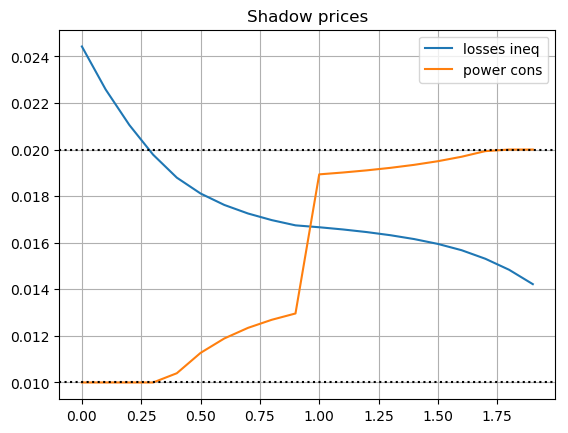

In [213]:
plot(t, dual.(m[:losses]), label="losses ineq")
plot(t, dual.(m[:Pcons]), label="power cons")
axhline(0.1*dt, c="k", ls=":")
axhline(0.2*dt, c="k", ls=":")
title("Shadow prices")
legend()
grid()

### Charge/discharge asymetric losses

TO BE DONE, based on PWL losses

## Test case B: production shifting

Note: this case is very similar to the load shifting. The difference are:
1. signals are vertically flipped (as if time got reversed)
2. for lossy cases, grid injection is <1kWh, while grid consumption is >1kWh in the load shifting scenario

The interest of this test case is that it's closer to the [Production at negative price](Relaxation_failure_example.ipynb) example which shows one failure of losses relaxation.

System: grid injection (power $P_{grid}$), storage ($P_b$, with receptor convention) and prod ($P_{prod}$).

Power flow conservation:
$$ P_{grid} = P_{prod} - P_b $$

Storage dynamics:
$$E_b(k+1) = E_b(k+1) + (P_b(k)-P_{loss}(k))\Delta_t$$

Objective: maximize production sale revenue:

$$ \max C_{grid} = \sum_{k} c_{grid}(k) P_{grid}(k)$$

### Experience definition

Scenario: a two hours experience with:

- first hour: low electricity price (0.1 €/kWh), 1 kW production (i.e. 1kWh  production)
- second hour: high price (0.2 €/kWh), no production

Parameters: 
- 1.0 kWh battery, to allow a 100% production shifting (less than 1.0 is needed when there are charging losses)
- 1.5 kW grid, to allow non constant discharging

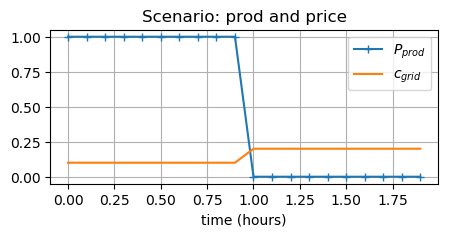

E_prod: 1.000 kWh

In [150]:
# Time vector: 2 hours, 0.1 h time step
n = 2*10
dt = 0.1
t = (0:n-1)*dt;

E_rated = 1.0 # kWh
P_grid_max = 1.5 # kW
P_prod = [ones(n÷2)
          zeros(n÷2)]
c_grid = [ones(n÷2)*0.1
          ones(n÷2)*0.2] # €/kWh

figure(figsize=(5,2.))
plot(t, P_prod, "+-", label="\$P_{prod}\$")
plot(t, c_grid, label="\$c_{grid}\$")
xlabel("time (hours)")
title("Scenario: prod and price")
legend()
grid(true)

@printf("E_prod: %.3f kWh", sum(P_prod*dt))

### 0. Defining a base problem in JuMP

to be reused by all subsequent problems

In [151]:
"""
    prod_shift_base(optimizer)

Create a base JuMP pour the production shifting optimization problem.
P_loss variable needs to be constrained.

`optimizer` should be an optimized factory passed to `JuMP.Model`.

If `slit_Pb` is true, then two extra variables are introduced:
`Pb_pos` and `Pb_neg`, the positive and negative parts of the
storage power `Pb`. That is Pb == Pb_pos - Pb_neg.
"""
function prod_shift_base(optimizer; split_Pb=false)
    m = Model(optimizer)
    # silence solver output
    set_silent(m)
    
    # Variables:
    @variable(m, 0. <= Eb[1:n+1] <= E_rated) # storage energy
    @variable(m, Pb[1:n]) # storage power
    @variable(m, P_losses[1:n]) # storage losses
    @variable(m, 0. <= P_grid[1:n] <= P_grid_max) # grid power
    @variable(m, C_grid) # Total grid cost
    
    # Power flow
    @constraint(m, Pcons[k = 1:n],
                P_grid[k] == P_prod[k] - Pb[k])
    # Storage dynamics
    @constraint(m, Edyn[k = 1:n], 
                Eb[k+1] == Eb[k] + (Pb[k] - P_losses[k])*dt)
    # Initial energy: empty
    @constraint(m, Eb_ini, Eb[1] == 0.)
    # Total grid cost
    @constraint(m, C_grid == sum(P_grid .* c_grid)*dt)
    
    if split_Pb
        @variable(m, Pb_pos[1:n] >= 0.) # storage power positive part
        @variable(m, Pb_neg[1:n] >= 0.) # storage power negative part
        
        @constraint(m, Pb .== Pb_pos - Pb_neg)
    end
    
    @objective(m, Max, C_grid)
    
    return m
end

prod_shift_base

Plot

In [152]:
figsize = (5,3) # for paper inclusion

(5, 3)

In [172]:
"""
    prod_plot(model)

Plot the optimization results of production shifting problem from JuMP `model`
"""
function prod_plot(model, title_start="")
    # Check optimization
    if termination_status(m) != MOI.OPTIMAL &&  termination_status(m) != MOI.LOCALLY_SOLVED
        error("The model was not solved correctly.")
    end
    
    # Collect results
    P_grid = value.(m[:P_grid])
    Pb = value.(m[:Pb])
    Eb = value.(m[:Eb])
    P_losses = value.(m[:P_losses])
    
    E_grid = round(sum(P_grid)*dt, digits=6)
    C_grid = round(value.(m[:C_grid]), digits=6)
    
    # Plot:
    figure(figsize = figsize)
    plot(t, P_grid, "x-", label="\$P_{grid}\$", ms=10)
    plot(t, Eb[1:end-1], "-", label="\$E_b\$")
    plot(t, -Pb, "o-", label="\$-P_b\$", ms=4)
    plot(t, P_losses, "d-", label="\$P_{losses}\$")
    
    legend(ncol=2, loc="lower right")
    #xlabel("time (hours)")
    #ylabel("kW, kWh")
    ylim(-1.15, 1.65)
    title(@sprintf("%s (\$E_{grid}\$ %.3f kWh, \$C_{grid}\$ %.4f €)", title_start, E_grid, C_grid))
    grid(true)
    tight_layout(pad=0)
end

prod_plot

### LP version: no losses

and adding a small *increasing* on $P_{grid}$ for unicity, that is an incentive to sell as soon as possible.

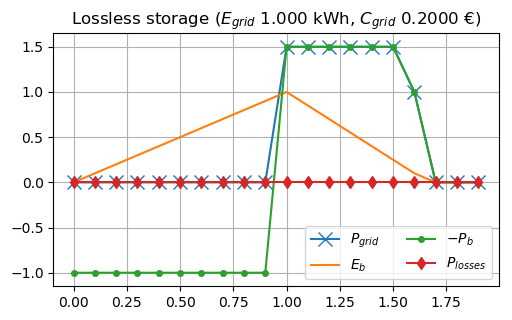

In [170]:
m = prod_shift_base(ECOS.Optimizer)

# no losses:
@constraint(m, losses, m[:P_losses] .== 0.0)

# small penalty: sell as early as possible
seq0_1 = (0:n-1)/(n-1) # increasing sequence from 0 to 1 on k=1:n
discount = seq0_1 * 1e-5
penal = sum(m[:P_grid] .* discount)

# Redefine the objective to add the penalty:
@objective(m, Max, m[:C_grid] - penal)

optimize!(m)

prod_plot(m, "Lossless storage")
savefig("scenario plots/prod_shift_lossless.pdf")
savefig("scenario plots/prod_shift_lossless.png", dpi=300)

#### Variant: linear-in-$E_b$ losses (self discharge)

$P_{losses} = c_E E_b$

-> this makes the solution unique wih the need for the penalty of $P_{grid}$.
Indeed, there is an interest to _discharge as soon as possible_.

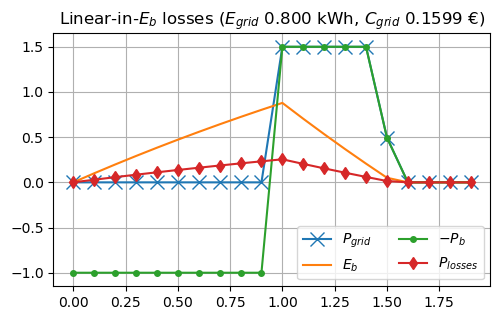

Max stored energy: Eb(1h) = 0.8791 kWh

In [176]:
m = prod_shift_base(ECOS.Optimizer)

# discharge proportional to storage energy:
@constraint(m, losses, m[:P_losses] .== 0.29*m[:Eb][1:end-1])

optimize!(m)

prod_plot(m, "Linear-in-\$E_b\$ losses")

savefig("scenario plots/prod_shift_linE.pdf")
savefig("scenario plots/prod_shift_linE.png", dpi=300)

@printf("Max stored energy: Eb(1h) = %.4f kWh", value(m[:Eb][n÷2+1]))


### LP: piecewise linear losses (PWL)

Formulated using splitting of positive and negative parts Pb+ and Pb-

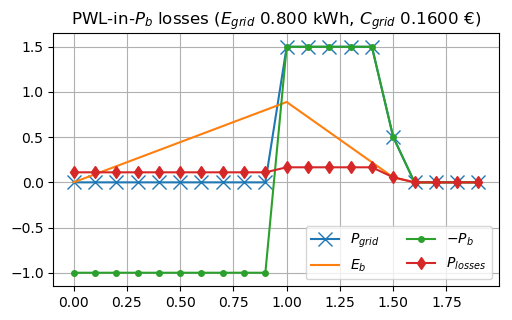

Max stored energy: Eb(1h) = 0.8890 kWh

In [173]:
m = prod_shift_base(ECOS.Optimizer, split_Pb=true)

# PWL losses
c = 0.111
@constraint(m, losses, m[:P_losses] .== c*m[:Pb_pos] + c*m[:Pb_neg])

# small penalty: sell as early as possible
seq0_1 = (0:n-1)/(n-1) # increasing sequence from 0 to 1 on k=1:n
discount = seq0_1 * 1e-5
penal = sum(m[:P_grid] .* discount)

# Redefine the objective to add the penalty:
@objective(m, Max, m[:C_grid] - penal)

optimize!(m)

prod_plot(m, "PWL-in-\$P_b\$ losses")
@printf("Max stored energy: Eb(1h) = %.4f kWh", value(m[:Eb][n÷2+1]))

savefig("scenario plots/prod_shift_PWL.pdf")
savefig("scenario plots/prod_shift_PWL.png", dpi=300)

#### When PWL losses are high

c = 0.33 seems to be the turning point

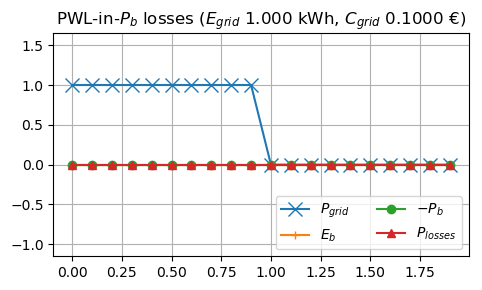

Max stored energy: Eb(1h) = 0.0000 kWh

In [61]:
m = prod_shift_base(ECOS.Optimizer, split_Pb=true)

# PWL losses
c = 0.34 #
@constraint(m, losses, m[:P_losses] .== c*m[:Pb_pos] + c*m[:Pb_neg])

# small penalty: sell as early as possible
seq0_1 = (0:n-1)/(n-1) # increasing sequence from 0 to 1 on k=1:n
discount = seq0_1 * 1e-5
penal = sum(m[:P_grid] .* discount)

# Redefine the objective to add the penalty:
@objective(m, Max, m[:C_grid] - penal)

optimize!(m)

prod_plot(m, "PWL-in-\$P_b\$ losses")
@printf("Max stored energy: Eb(1h) = %.4f kWh", value(m[:Eb][n÷2+1]))

### SOCP version: no losses, penalty for RMS value of $P_b$

RMS value of the storage power, in discrete time:

$$ P_{b,rms} = \sqrt{\sum_{k=1}^n P_b^2(k)/n} = \lVert P_b \rVert / \sqrt{n}$$

This can be written as a SOC constraint (see [JuMP doc on quadratic constraints](https://jump.dev/JuMP.jl/stable/constraints/#Quadratic-constraints-1)):

$$ \lVert P_b \rVert \leq P_{b,rms}.\sqrt{n} $$

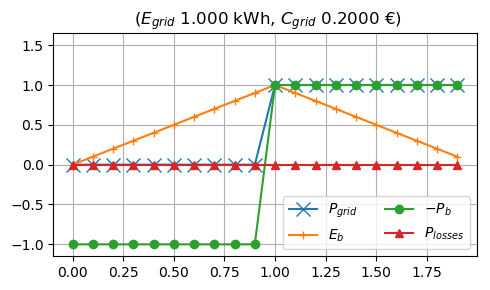

Pb_rms: 1.000 kW

In [62]:
m = prod_shift_base(ECOS.Optimizer)

# no losses:
@constraint(m, losses, m[:P_losses] .== 0.0)

@variable(m, Pb_rms)
@constraint(m, [Pb_rms*sqrt(n); m[:Pb]] in SecondOrderCone())

# Redefine the objective to add the penalty:
@objective(m, Max, m[:C_grid] - 0.01*Pb_rms) # penalty coefficient should be < 0.1

optimize!(m)

prod_plot(m)

Pb_rms = value(Pb_rms)
@printf("Pb_rms: %.3f kW", Pb_rms)

Variant with moderately high penalty: 0.1 is a turning point

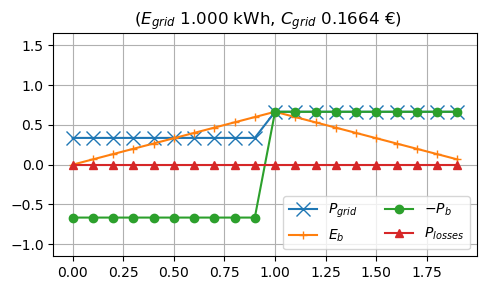

Pb_rms: 0.664 kW

In [63]:
m = prod_shift_base(ECOS.Optimizer)

# no losses:
@constraint(m, losses, m[:P_losses] .== 0.0)

@variable(m, Pb_rms)
@constraint(m, [Pb_rms*sqrt(n); m[:Pb]] in SecondOrderCone())

# Redefine the objective to add the penalty:
@objective(m, Max, m[:C_grid] - 0.10*Pb_rms) # penalty coefficient should be < 0.1

optimize!(m)

prod_plot(m)

Pb_rms = value(Pb_rms)
@printf("Pb_rms: %.3f kW", Pb_rms)

### QCQP version: quadratic storage losses

Quadratic loss model

$$P_{loss} = \rho P_{sto}^2$$

**Note** why does it work with ECOS? I thought ECOS only accepted SOC constraints, not generic quadratic ones

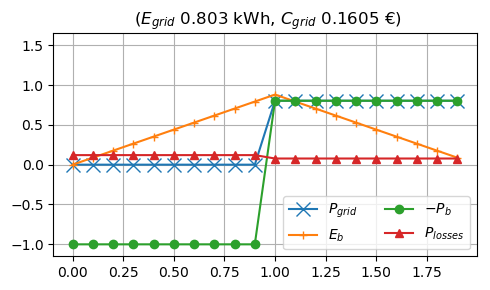

In [64]:
ρ0 = 0.12 # kW/kW²

m = prod_shift_base(ECOS.Optimizer)

# Quadratic losses as (convex) Quad Constraint:
@constraint(m, losses, m[:P_losses] .>= ρ0 * m[:Pb].^2)

optimize!(m)

prod_plot(m)

savefig("scenario plots/prod_shift_PWL.pdf")
savefig("scenario plots/prod_shift_PWL.png", dpi=300)

Check that there are not excess of losses

In [65]:
P_excess = value.(m[:P_losses] - ρ0 * m[:Pb].^2)
maximum(abs.(P_excess))

9.013609303387682e-11

#### Variant with higher losses

-> Arbitrage becomes fractional: grid is used to partially feed the load

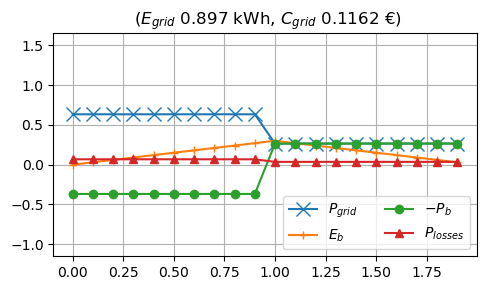

In [66]:
ρ0 = 0.5 # kW/kW²

m = prod_shift_base(ECOS.Optimizer)

# Quadratic losses as (convex) Quad Constraint:
@constraint(m, losses, m[:P_losses] .>= ρ0 * m[:Pb].^2)

optimize!(m)

prod_plot(m)

### NLP version: convex losses R(SoE).$P_{sto}^2$

See JuMP doc on [Nonlinear Modeling](https://jump.dev/JuMP.jl/v0.21.1/nlp/)

$$P_{loss} = \frac{c}{(E_b - e_0)^a} P_{sto}^2$$

In [97]:
c = 0.075
a = 1.
e0 = -0.25*E_rated

-0.3

Show the loss factor $\rho(E_b)$ 

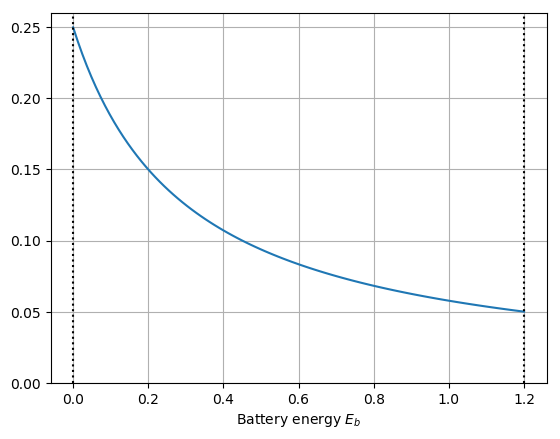

In [98]:
Eb_list = range(0, E_rated, length=100)

ρ_Eb = c./(Eb_list .- e0).^a

plot(Eb_list, ρ_Eb)
xlabel("Battery energy \$E_b\$")
axvline(0, color="k", ls=":")
axvline(E_rated, color="k", ls=":")
ylim(ymin=0)
grid()

Solve

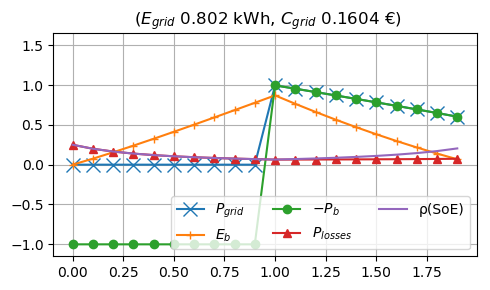

In [99]:
m = prod_shift_base(Ipopt.Optimizer)

# Convex monomial losses expression
@NLexpression(m, ρ[k = 1:n], c/(m[:Eb][k] - e0)^a)
@NLconstraint(m, losses[k = 1:n], m[:P_losses][k] >= ρ[k] * m[:Pb][k]^2)

# Optimize and check result
optimize!(m)

prod_plot(m)

ρ = value.(ρ)

plot(t, ρ, "-", label="ρ(SoE)")
legend(ncol=3, loc="lower right");

Now, with a bit more losses, some energy is sold at low price to the grid at the beginning of the charge.

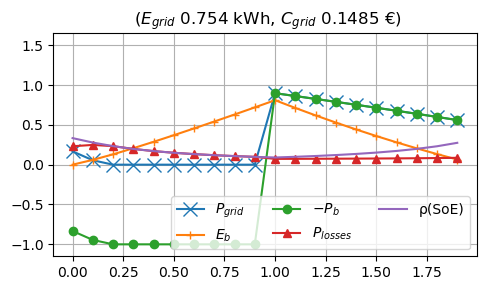

In [101]:
c = 0.1

m = prod_shift_base(Ipopt.Optimizer)

# Convex monomial losses expression
@NLexpression(m, ρ[k = 1:n], c/(m[:Eb][k] - e0)^a)
@NLconstraint(m, losses[k = 1:n], m[:P_losses][k] >= ρ[k] * m[:Pb][k]^2)

# Optimize and check result
optimize!(m)

prod_plot(m)

ρ = value.(ρ)

plot(t, ρ, "-", label="ρ(SoE)")
legend(ncol=3, loc="lower right");

Checking the absence of excess losses: OK

In [102]:
P_excess = value.(m[:P_losses] - ρ .* m[:Pb].^2)
maximum(abs.(P_excess))

1.5377260942361914e-7

#### Looking at duals (shadow prices)

TO BE CONTINUED

In [103]:
[dual.(m[:Edyn]) dual.(m[:losses]) dual.(m[:Pcons]) ]

20×3 Array{Float64,2}:
 -0.224866  0.0224866  -0.01
 -0.210387  0.0210387  -0.01
 -0.199586  0.0199586  -0.0106727
 -0.192101  0.0192101  -0.0116262
 -0.186681  0.0186681  -0.0123061
 -0.182611  0.0182611  -0.0128086
 -0.179461  0.0179461  -0.0131915
 -0.176963  0.0176963  -0.0134912
 -0.17494   0.017494   -0.0137309
 -0.173271  0.0173271  -0.0139263
 -0.172144  0.0172144  -0.02
 -0.170906  0.0170906  -0.02
 -0.169537  0.0169537  -0.02
 -0.168015  0.0168015  -0.02
 -0.166309  0.0166309  -0.02
 -0.164379  0.0164379  -0.02
 -0.162173  0.0162173  -0.02
 -0.159619  0.0159619  -0.02
 -0.156615  0.0156615  -0.02
 -0.153006  0.0153006  -0.02

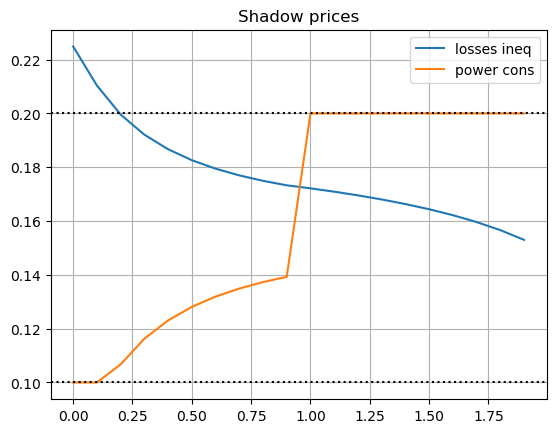

In [107]:
plot(t, dual.(m[:losses])/dt, label="losses ineq")
plot(t, -dual.(m[:Pcons])/dt, label="power cons")
axhline(0.1, c="k", ls=":")
axhline(0.2, c="k", ls=":")
title("Shadow prices")
legend()
grid()

### Charge/discharge asymetric losses

a case where it's the end of the charge and the end of discharge which is very lossy.

In [147]:
cd = 0.06
cc = cd*3

a = 1.
e0c = 1.1*E_rated # end of charge gets difficult
e0d = -0.25*E_rated # end of discharge gets difficult

-0.3

Show the loss factor $\rho(E_b)$ 

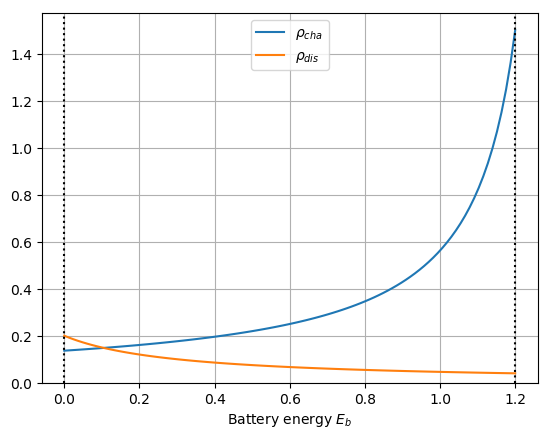

In [148]:
Eb_list = range(0, E_rated, length=100)

ρc_Eb = cc./(-Eb_list .+ e0c).^a
ρd_Eb = cd./(Eb_list .- e0d).^a

plot(Eb_list, ρc_Eb, label="\$\\rho_{cha}\$")
plot(Eb_list, ρd_Eb, label="\$\\rho_{dis}\$")

xlabel("Battery energy \$E_b\$")
axvline(0, color="k", ls=":")
axvline(E_rated, color="k", ls=":")
legend()
ylim(ymin=0)
grid()

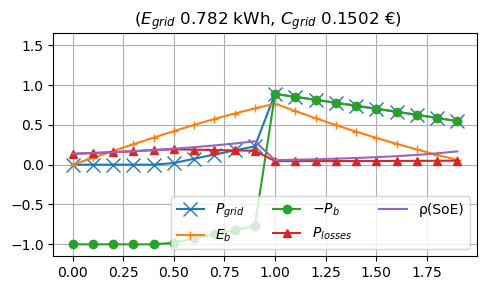

In [149]:
m = prod_shift_base(Ipopt.Optimizer, split_Pb=true)


# Convex monomial losses expression
@NLexpression(m, ρc[k = 1:n], cc/(-m[:Eb][k] + e0c)^a)
@NLexpression(m, ρd[k = 1:n], cd/(m[:Eb][k] - e0d)^a)
@NLconstraint(m, losses[k = 1:n],
             m[:P_losses][k] >= ρc[k] * m[:Pb_pos][k]^2 + ρd[k] * m[:Pb_neg][k]^2)

optimize!(m)

prod_plot(m)

ρc = value.(ρc)
ρd = value.(ρd)
ρ = copy(ρd)
charging = value.(m[:Pb]) .> 0. 
ρ[charging] = ρc[charging]
plot(t, ρ, "-", label="ρ(SoE)")

#fig = gcf()
legend(ncol=3, loc="lower right");